In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib

import scipy.stats

import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

from misc import model_alias, rna_models

matplotlib.rcParams.update({'font.size': 20})

In [3]:
def reverse_complement(seq):
    '''
    Take sequence reverse complement
    '''
    compl_dict = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    compl_seq = ''.join([compl_dict.get(x,x) for x in seq])
    rev_seq = compl_seq[::-1]
    return rev_seq

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)]
    n = len(a)
    m, se = np.nanmean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [4]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

In [5]:
utr_variants = pd.read_csv(data_dir + 'all_scores/variant_scores.tsv.gz', sep='\t')


splits = ['clinvar','gnomAD','eQTL-susie','CADD',]

In [6]:
utr_variants = utr_variants.sort_values(by=['split','label','chrom','var_id']).set_index(['split','label'])

In [7]:
cats = [('clinvar', 1.0), ('gnomAD', 1.0),('eQTL-susie', 1.0),('CADD', 1.0),
       ('gnomAD', 0.0), ('CADD', 0.0) ]

utr_variants = utr_variants.loc[cats]

## conservation in neighbourhood

In [8]:
cats_color = {('clinvar', 1.0): 'tomato',
              ('gnomAD', 1.0): 'tomato',
              ('eQTL-susie', 1.0): 'tomato',
              ('CADD', 1.0): 'tomato',
              ('gnomAD', 0.0): 'deepskyblue',
              ('CADD', 0.0): 'deepskyblue'}

In [9]:
model = 'PhyloP-241way'
model_pickle = data_dir + 'human_3utr/probs/' + model_alias[model] + '/predictions.pickle'

with open(model_pickle,'rb') as f:
    model_probs = pickle.load(f)
    model_probs = {seq_name:{'probs':prob,'seq':seq} for seq_name,prob,seq in 
                  zip(model_probs['seq_names'],model_probs['probs'],model_probs['seqs'])}

In [10]:
all_probs = []
for seq_name in model_probs:
    all_probs.extend(model_probs[seq_name]['probs'])

background_median = np.nanmedian(all_probs)
#thr = np.nanpercentile(all_probs,q=90)

In [11]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [12]:
res = defaultdict(list)

W = 128

for cat,var in tqdm(utr_variants.iterrows(),total=len(utr_variants)):
    if var.seq_name in model_probs:
        prob = model_probs[var.seq_name]['probs']
        seq = model_probs[var.seq_name]['seq']
        #if model in rna_models:
        #    if var.strand=='-':
        #        prob = prob[::-1,[3,2,1,0]]
        #        seq = reverse_complement(seq)
        #    #prob = [prob[pos_idx, mapping[nt]] for pos_idx, nt in enumerate(seq)]
        #    prob = np.max(prob,1)
        assert seq[var.pos_rel] == var.ref
        av_cons_bin = np.nanmedian(np.hstack((prob[max(var.pos_rel-W//2,0):var.pos_rel],
                                            prob[var.pos_rel+1:var.pos_rel+W//2])))
        res[cat].append(av_cons_bin)

  0%|          | 1/50261 [00:00<10:46:37,  1.30it/s]/tmp/ipykernel_3787538/4166367441.py:16: RuntimeWarning: All-NaN slice encountered
  av_cons_bin = np.nanmedian(np.hstack((prob[max(var.pos_rel-W//2,0):var.pos_rel],
100%|██████████| 50261/50261 [00:07<00:00, 6850.25it/s]


In [13]:
res = [( k,*mean_confidence_interval(v)) for k,v in res.items()]
res_df = pd.DataFrame(res,columns=['cat','cons_mean','cons_ci'])
res_df['color'] = res_df.cat.map(cats_color)
cat_remap = {(split,label):f'{split}-F' if label==1 else f'{split}-NF' for split,label in cats}
res_df.cat = res_df.cat.map(cat_remap)

In [15]:
res_df

,cat,cons_mean,cons_ci,color
0,clinvar-F,1.875693,0.219174,tomato
1,gnomAD-F,0.636149,0.021923,tomato
2,eQTL-susie-F,0.370996,0.014632,tomato
3,CADD-F,0.639043,0.022474,tomato
4,gnomAD-NF,0.372864,0.015184,deepskyblue
5,CADD-NF,0.416111,0.016004,deepskyblue


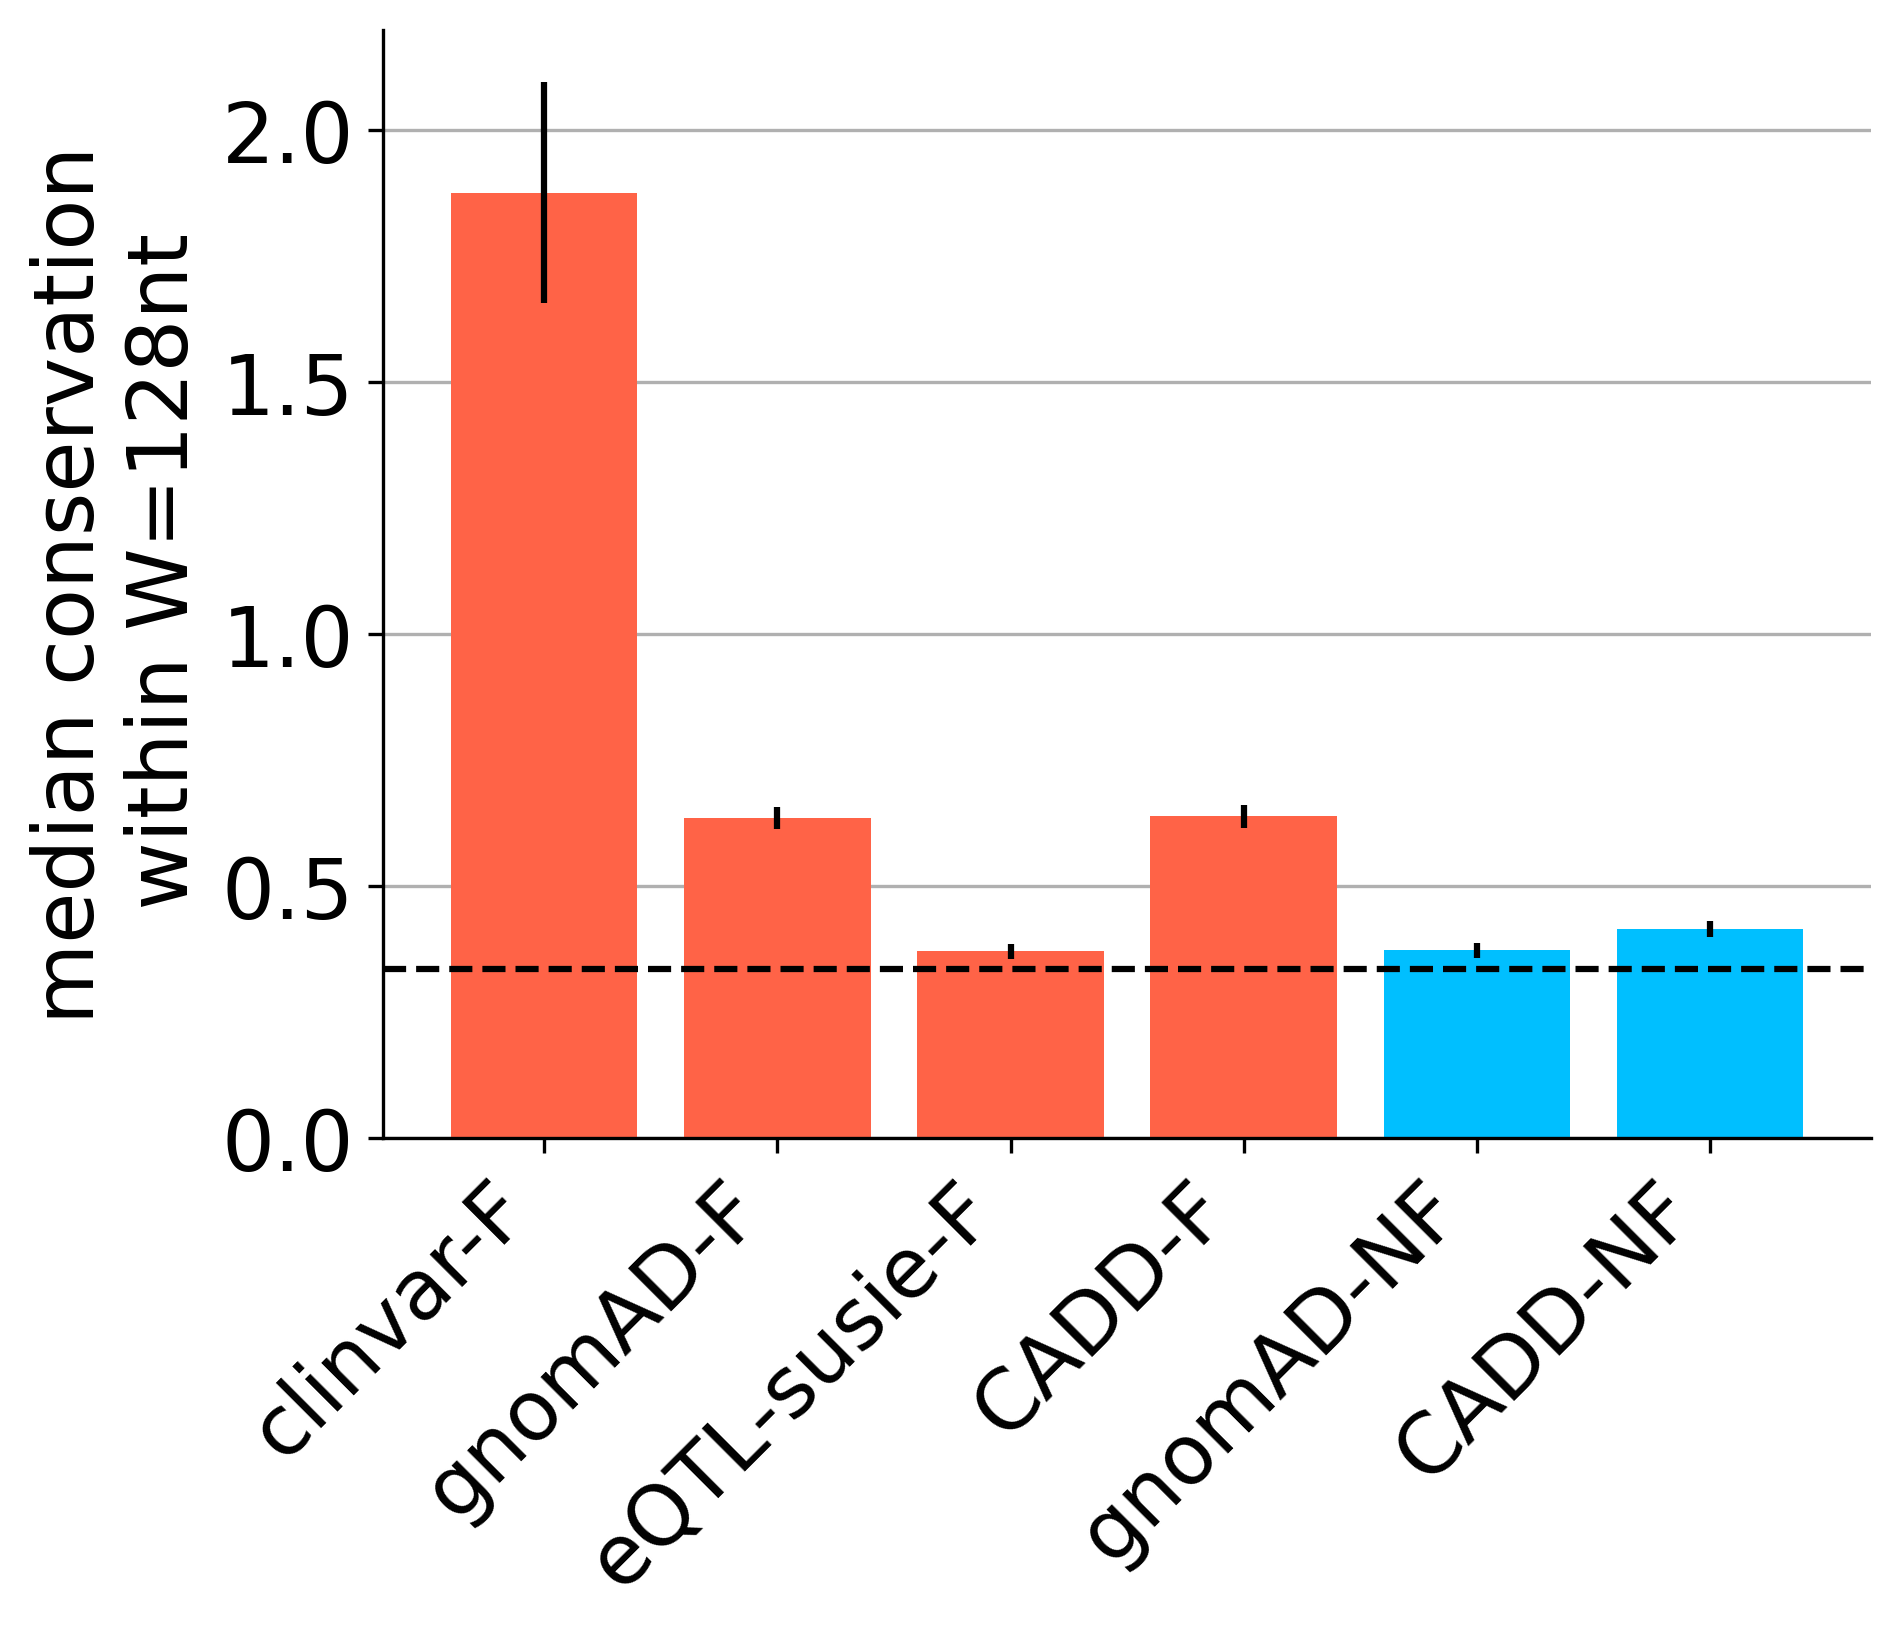

In [14]:
fig, ax = plt.subplots(dpi=300)

ax.bar(res_df.cat,height=res_df.cons_mean,yerr=res_df.cons_ci,color=res_df.color)
ax.axhline(background_median,linestyle='--',color='k')
ax.set_ylabel(f'median conservation\n within W={W}nt')
ax.set_xticks(range(len(res_df)))
ax.set_xticklabels(res_df.cat, rotation=45, ha='right');

ax.grid(axis='y')
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## variant collocalisation

In [378]:
res = defaultdict(list)

W = 256

for ref_cat in cats:
    for query_cat in cats:
        ref_df = utr_variants.loc[ref_cat].set_index('chrom')
        query_df = utr_variants.loc[query_cat].set_index('chrom')
        for chrom in ref_df.index.unique():
            if chrom in query_df.index:
                ref_id, ref_pos = ref_df.loc[[chrom],['var_id','pos']].values.T
                query_id, query_pos = query_df.loc[[chrom],['var_id','pos']].values.T
                for ref_var_id,ref_var_pos in zip(ref_id,ref_pos):
                    dist = abs(query_pos-ref_var_pos)
                    n_others = (dist<W).sum()
                    if ref_var_id in query_id:
                        n_others -= 1
                    res[(ref_cat,query_cat)].append(n_others)

In [379]:
res = [(k[0],k[1],(np.mean(v),np.std(v))) for k,v in res.items()]
res_df = pd.DataFrame(res,columns=['ref','query','n_vars'])
#res_df = pd.pivot(res_df,index='ref',columns='query').map(lambda x:f'{x[0]:.2f}±{x[1]:.2f}')
res_df = pd.pivot(res_df,index='ref',columns='query').map(lambda x:x[0].round(2))

In [380]:
res_df.columns = res_df.columns.droplevel()
res_df = res_df.loc[cats,cats]
cat_remap = {(split,label):f'{split}-F' if label==1 else f'{split}-NF' for split,label in cats}
res_df.index = res_df.index.map(cat_remap)
res_df.columns = res_df.columns.map(cat_remap)

In [381]:
res_df

query,clinvar-F,gnomAD-F,eQTL-susie-F,CADD-F,gnomAD-NF,CADD-NF
ref,,,,,,
clinvar-F,6.01,0.27,0.52,0.37,0.03,0.13
gnomAD-F,0.01,0.15,0.16,0.16,0.15,0.15
eQTL-susie-F,0.01,0.16,0.98,0.15,0.10,0.17
CADD-F,0.01,0.15,0.15,0.17,0.16,0.16
gnomAD-NF,0.00,0.15,0.10,0.16,0.34,0.18
CADD-NF,0.00,0.15,0.17,0.16,0.17,0.25
